## Import packages

In [4]:
import numpy as np
import pandas as pd 
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
import scipy.stats as stats
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

## Import data

In [12]:
customer_response = pd.read_csv("customer_response_final.csv", sep = ";")
customer_response.head()

,individualnumber,discount_type1_count,discount_type1_mean,discount_type2_count,discount_type2_mean,discount_type3_count,discount_type3_mean,Hygiene_Quantity,Hygiene_Amount,Other_Quantity,...,PersonalCare_Amount,Beverage_Quantity,Beverage_Amount,isvirtual_ratio,gender,dateofbirth,category_number,deserved_amount,reward_amount,response
0,100001590,0,0.000000,1,2.340000,0,0.000000,0.0,0.0,0.0,...,0.00,3.0,16.05,0.0000,0,2000,9000,17.0,1.0,0
1,100002863,40,1.343845,36,4.548333,20,11.040500,12.0,197.9,28.0,...,313.04,60.0,216.25,0.5238,1,1990,9030,18.0,1.0,0
2,100020001,24,1.659298,4,16.190000,15,6.892667,19.0,515.3,9.0,...,0.00,15.0,75.50,0.0000,1,1983,9040,23.0,2.0,0
3,100025528,0,0.000000,1,4.000000,0,0.000000,1.0,19.9,0.0,...,9.60,6.0,28.05,0.0000,0,1976,9004,66.0,6.0,0
4,100027007,0,0.000000,5,9.078000,12,14.855833,4.0,59.9,5.0,...,349.41,7.0,54.00,0.0000,1,1981,9046,79.0,7.0,0


In [6]:
customer_response.isnull().values.any()

False

### Z-Score Normalization

In [7]:
Columns_norm = ['reward_amount', 'deserved_amount', 'Hygiene_Quantity', 'Hygiene_Amount',
       'Other_Quantity', 'Other_Amount', 'Food_Quantity', 'Food_Amount',
       'PersonalCare_Quantity', 'PersonalCare_Amount', 'Beverage_Quantity',
       'Beverage_Amount']

In [8]:
cr = customer_response.copy()

In [10]:
for i in Columns_norm:
    cr[i] = stats.zscore(cr[i])
    

### Split X and y

In [11]:
X = cr.drop(columns = ['response','individualnumber','gender','dateofbirth'])
y = cr['response']

---

### XGBClassifier 

In [202]:
# create a 5-fold cross validation iterator 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# specify the hyperparameters to tune and their possible values
param_grid = {
    'max_depth': [10],
    'scale_pos_weight': [150],
    'learning_rate': [0.01],
    'n_estimators': [1200],
    'random_state': [42, 58],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8],
    'min_child_weight': [6 ,8, 10]
}

# create the model to tune
model = xgb.XGBClassifier()

# create the GridSearchCV object
grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='f1', n_jobs=-1)

# fit the GridSearchCV object to the data
grid_search.fit(X, y)

# print the best hyperparameters
print("Best hyperparameters: {}".format(grid_search.best_params_))

Best hyperparameters: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 8, 'n_estimators': 1200, 'random_state': 42, 'scale_pos_weight': 150, 'subsample': 0.8}


In [203]:
#initialize an empty list to store the F1 scores for each fold
f1_scores = []

for train_index, val_index in cv.split(X, y):
    # split the data into train and validation sets for this fold
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # create the XGBoost model and fit it to the training data
    model = xgb.XGBClassifier(**grid_search.best_params_)
    model.fit(X_train, y_train)

    # make predictions on the validation set
    y_pred = model.predict(X_val)

    # calculate the F1 score for this fold
    fold_f1_score = f1_score(y_val, y_pred)
    f1_scores.append(fold_f1_score)

    print("Fold F1 score: {:.4f}".format(fold_f1_score))

Fold F1 score: 0.3953
Fold F1 score: 0.4301
Fold F1 score: 0.4773
Fold F1 score: 0.4545
Fold F1 score: 0.4898


In [205]:
# calculate the mean F1 score across all folds
mean_f1score_XGB = sum(f1_scores) / len(f1_scores)
print("Mean F1 score: {:.4f}".format(mean_f1_score))

Mean F1 score: 0.4494


---

### Logistic Regression

In [ ]:
# Define the hyperparameters to tune
param_grid = {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2']}

# Initialize the logistic regression model
log_reg = LogisticRegression()

# Create a StratifiedKFold object
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the grid search object
grid_search = GridSearchCV(log_reg, param_grid, cv=kf, scoring='f1')

# Fit the grid search object to the data
grid_search.fit(X, y)

In [24]:
# Print the best hyperparameters
print('Best Hyperparameters:', grid_search.best_params_)

Best Hyperparameters: {'C': 0.1, 'penalty': 'l2'}


In [25]:
# Print the best accuracy
print('Best Accuracy:', grid_search.best_score_)

Best Accuracy: 0.16319936779743344


In [ ]:
# Perform cross-validation using the best parameters
log_reg_best = LogisticRegression(**grid_search.best_params_)
cv_scores = cross_val_score(log_reg_best, X, y, cv=kf, scoring='f1')

# Print the cross-validation scores
print('Cross-validation scores:', cv_scores

Cross-validation scores: 0.16326531 0.15686275 0.19607843 0.11111111 0.18867925

In [27]:
print('Mean cross-validation score:', np.mean(cv_scores));

Mean cross-validation score: 0.16319936779743344


---

### GradientBoostingClassifier

In [13]:
# Create a StratifiedKFold object
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the hyperparameters to tune
param_grid = {'n_estimators': [50, 100, 150], 'max_depth': [3, 5, 10]}

# Initialize the gradient boosting classifier
gbc = GradientBoostingClassifier()

# Initialize the grid search object
grid_search = GridSearchCV(gbc, param_grid, cv=kf, scoring='f1_macro')

# Fit the grid search object to the data
grid_search.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=GradientBoostingClassifier(),
             param_grid={'max_depth': [3, 5, 10],
                         'n_estimators': [50, 100, 150]},
             scoring='f1_macro')

In [14]:
# Print the best hyperparameters
print('Best Hyperparameters:', grid_search.best_params_)

Best Hyperparameters: {'max_depth': 3, 'n_estimators': 150}


In [15]:
# Print the best accuracy
print('Best F1 Score:', grid_search.best_score_)

Best F1 Score: 0.6426635199939363


In [16]:
# Perform cross-validation using the best parameters
gbc_best = GradientBoostingClassifier(**grid_search.best_params_)
cv_scores = cross_val_score(gbc_best, X, y, cv=kf, scoring='f1_macro')

# Print the cross-validation scores
print('Cross-validation F1 Scores:', cv_scores)

Cross-validation F1 Scores: [0.63384225 0.64237681 0.61830016 0.60286104 0.70841606]


In [17]:
print('Mean cross-validation F1 score:', np.mean(cv_scores))

Mean cross-validation F1 score: 0.6411592645024051


### Confusion Matrix

In [24]:
# Get the predictions from the model
y_pred = gbc_best.predict(X)

# Calculate true positives (TP), false positives (FP), true negatives (TN), false negatives (FN)
TP = np.sum((y_pred == 1) & (y == 1))
FP = np.sum((y_pred == 1) & (y == 0))
TN = np.sum((y_pred == 0) & (y == 0))
FN = np.sum((y_pred == 0) & (y == 1))

# Create a confusion matrix with the calculated values
conf_matrix = pd.DataFrame({"False Positive": [FP],
                            "True Positive": [TP],
                            "False Negative": [FN],
                            "True Negative": [TN]
                            })
# Print the confusion matrix
print(conf_matrix)


   False Positive  True Positive  False Negative  True Negative
0               2            127              82          12774


### ROC Curve

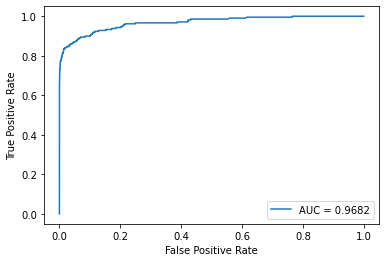

In [19]:
# Predict the probabilities of the positive class
y_prob = gbc_best.predict_proba(X)[:, 1]

# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y, y_prob)

# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='AUC = %0.4f' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

### Feature Importance Plot:

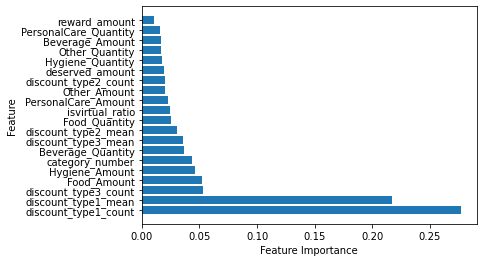

In [20]:
# Compute feature importances
importances = gbc_best.feature_importances_

# Sort the features by importance
indices = np.argsort(importances)[::-1]

# Create a list of feature names
feature_names = X.columns

# Plot the feature importances
plt.barh(range(X.shape[1]), importances[indices])
plt.yticks(range(X.shape[1]), feature_names[indices])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()